In [2]:
import os
from keras import applications
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils.np_utils import to_categorical 
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras import Model
from keras import initializers
from keras.callbacks import LearningRateScheduler
from keras.utils import layer_utils, np_utils
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from classification_models import ResNet18
from classification_models.resnet import preprocess_input as resnet_preprocess_input
from keras.applications.densenet import preprocess_input as densenet_preprocess_input
from keras.applications.vgg16 import preprocess_input as vgg_preprocess_input
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils import class_weight
import seaborn as sn
import pandas as pd
from scipy import interp
from itertools import cycle
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.externals import joblib
from sklearn.metrics import jaccard_similarity_score
from scipy import spatial
from scipy.spatial import distance
from ast import literal_eval

In [3]:
image_width = 224
image_height = 224

feature_scaler_filename = "D:/retinal_data_set_visioncare/Image_Retrieval/feature_scaler.save"
svd_scaler_file_name = "D:/retinal_data_set_visioncare/Image_Retrieval/svd_scaler.save"
file_path = 'D:/retinal_data_set_visioncare/Image_Retrieval/img_database.csv'

densenet_base = applications.DenseNet201(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))
resnet_base = ResNet18(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))
vgg_base = applications.VGG16(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

In [4]:
densenet_x = densenet_base.get_layer(index=-1).output
densenet_feature_extraction_layer = GlobalAveragePooling2D()(densenet_x)
densenet_model = Model(inputs=densenet_base.input, outputs=densenet_feature_extraction_layer)
densenet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [5]:
resnet_x = resnet_base.get_layer(index=-1).output
resnet_feature_extraction_layer = GlobalAveragePooling2D()(resnet_x)
resnet_model = Model(inputs=resnet_base.input, outputs=resnet_feature_extraction_layer)
resnet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

In [6]:
vgg_x = vgg_base.get_layer(index=-1).output
vgg_feature_extraction_layer = GlobalAveragePooling2D()(vgg_x)
vgg_model = Model(inputs=vgg_base.input, outputs=vgg_feature_extraction_layer)
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [7]:
# Returns a compiled model identical to the previous one
loaded_pretrained_deep_feature_model = load_model('D:/retinal_data_set_visioncare/models/ensemble/ensemble_deep_feature_with_SVD_dr.h5')
loaded_pretrained_deep_feature_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               35200     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
_________________________________________________________________
batch_normalization_4 (Batch (None, 5)                 20        
_________________________________________________________________
activation_4 (Activation)    (None, 5)                 0         
Total para

In [8]:
feature_extraction_layer = loaded_pretrained_deep_feature_model.get_layer('activation_3').output
feature_extract_model = Model(inputs=loaded_pretrained_deep_feature_model.input, outputs=feature_extraction_layer)
feature_extract_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3_input (InputLayer)   (None, 274)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               35200     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
Total params: 35,712
Trainable params: 35,456
Non-trainable params: 256
_________________________________________________________________


In [9]:
# Returns a compiled model identical to the previous one
loaded_deep_hash_model = load_model('D:/retinal_data_set_visioncare/Image_Retrieval/deep_hash_model.h5')
loaded_deep_hash_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 28)                3612      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28)                112       
_________________________________________________________________
activation_1 (Activation)    (None, 28)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 145       
_________________________________________________________________
batch_normalization_2 (Batch (None, 5)                 20        
_________________________________________________________________
activation_2 (Activation)    (None, 5)                 0         
Total params: 3,889
Trainable params: 3,823
Non-trainable params: 66
_________________________________________________________________


In [10]:
hashcode_extraction_layer = loaded_deep_hash_model.get_layer('activation_1').output
hashcode_extract_model = Model(inputs=loaded_deep_hash_model.input, outputs=hashcode_extraction_layer)
hashcode_extract_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1_input (InputLayer)   (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 28)                3612      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28)                112       
_________________________________________________________________
activation_1 (Activation)    (None, 28)                0         
Total params: 3,724
Trainable params: 3,668
Non-trainable params: 56
_________________________________________________________________


In [11]:
norm_scalar = joblib.load(feature_scaler_filename) 
norm_truncated_opt_svd = joblib.load(svd_scaler_file_name)

In [12]:
# retrieve deep hash code for a given query image
def get_deep_feature_hashcode_for_query_img(source):
    img = image.load_img(source, target_size=(image_width, image_height))
    img_x = image.img_to_array(img)
    img_x = np.expand_dims(img_x, axis=0)

    # densenet201 - feature extraction
    densenet201_x = densenet_preprocess_input(img_x)
    densenet201_extract_features = densenet_model.predict(densenet201_x)
    flattern_feature_vector = densenet201_extract_features.flatten()

    # resnet18 - feature extraction
    resnet18_x = resnet_preprocess_input(img_x)
    resnet18_extract_features = resnet_model.predict(resnet18_x)
    resnet18_feature_vector = resnet18_extract_features.flatten()

    # vgg16 - feature extraction
    vgg16_x = vgg_preprocess_input(img_x)
    vgg16_extract_features = vgg_model.predict(vgg16_x)
    vgg16_feature_vector = vgg16_extract_features.flatten()
    
    # create concatenated feature vector for a given image
    flattern_feature_vector = np.concatenate((flattern_feature_vector, resnet18_feature_vector, vgg16_feature_vector))
    # normlaize feature vector - standadization
    scaled_flattern_feature_vector = norm_scalar.transform(np.array([flattern_feature_vector]))
    # apply truncated SVD transform to reduce the dimentionality
    transformed_flattern_feature_vector = norm_truncated_opt_svd.transform(scaled_flattern_feature_vector)
    # predict the feature vector for the given input image
    ensemble_compressed_feature = feature_extract_model.predict(transformed_flattern_feature_vector)
    ensemble_compressed_feature_np = np.array([ensemble_compressed_feature.flatten()])
    # extract deep feature
    deep_feature = [val for val in ensemble_compressed_feature.flatten()]
    # extract deep hash code
    deep_hash_proba = hashcode_extract_model.predict(ensemble_compressed_feature_np)
    deep_hash_code = [1 if val >= 0.5 else 0 for val in deep_hash_proba.flatten()]
    deep_hash_code = "".join(map(str, deep_hash_code))

    return deep_feature, deep_hash_code

In [13]:
def get_jaccard_similarity_score(row_hash_code, query_hashcode):
    jaccard_sim = jaccard_similarity_score(row_hash_code, query_hashcode)
    return jaccard_sim

In [14]:
def get_cosine_similarity_score(row_deep_feature, query_feature):
    cosine_sim = 1 - spatial.distance.cosine(row_deep_feature, query_feature)
    return cosine_sim

In [15]:
# # this function work if row_hash_code and query_hash_code are in vectors form
# def get_hamming_distance(row_hash_code, query_hash_code):
#     hamming_distance = distance.hamming(row_hash_code, query_hashcode)
#     return hamming_distance

In [16]:
# this function work if row_hash_code and query_hash_code are string 
def get_hamming_distance(row_hash_code, query_hash_code):
    hamming_distance = sum(ch1 != ch2 for ch1, ch2 in zip(row_hash_code, query_hash_code))
    hamming_distance = hamming_distance / len(row_hash_code)
    return hamming_distance

In [17]:
# def get_hashcode_as_str(hash_code):
#     # Converting integer list to string list 
#     # and joining the list using join() 
#     #res = int("".join(map(str, hash_code)))
#     res = "".join(map(str, hash_code))
      
#     return res

In [19]:
# load dataset
#dataset = pd.read_csv(file_path, delimiter=',', converters=dict(deep_features=literal_eval, hash_code=literal_eval))

In [20]:
# load dataset
dataset = pd.read_csv(file_path, delimiter=',', converters=dict(deep_features=literal_eval))

In [21]:
#dataset["hash_code_as_str"] = dataset.apply(lambda x: get_hashcode_as_str(x['hash_code']), axis=1)

In [22]:
dataset.head()

,img_path,deep_features,hash_code
0,D:/retinal_data_set_visioncare/Image_Retrieval...,"[0.0, 0.0, 0.0, 0.0, 0.07835294, 0.0, 0.0, 0.0...",0001011000000111010011101000
1,D:/retinal_data_set_visioncare/Image_Retrieval...,"[0.0, 0.0, 0.0, 0.0, 0.08551569, 0.058963917, ...",0001000001000111001011101100
2,D:/retinal_data_set_visioncare/Image_Retrieval...,"[0.0, 0.0, 0.0, 0.0, 0.09744777, 0.10726792, 0...",0001010010000110111101010100
3,D:/retinal_data_set_visioncare/Image_Retrieval...,"[0.0, 0.0, 0.0, 0.0, 0.0884188, 0.13387582, 0....",0001000000000110001001000100
4,D:/retinal_data_set_visioncare/Image_Retrieval...,"[0.0, 0.0, 0.0, 0.0, 0.009470951, 0.0, 0.0, 0....",0001000001000110001001011100


In [23]:
# retrieve deep fature and deep hashcode for query image
#query_img_path = 'D:/retinal_data_set_visioncare/VISION_CARE/2/19570723__66594.JPG'
query_img_path = "D:/retinal_data_set_visioncare/Image_Retrieval/New_Train_Test_Data/test/2/19530319__52390.jpg"
query_deep_feature, query_deep_hash_code = get_deep_feature_hashcode_for_query_img(query_img_path)

#dataset["jaccard_sim"] = dataset.apply(lambda x: get_jaccard_similarity_score(x['hash_code'], query_deep_hash_code), axis=1)
dataset["hamming_dist"] = dataset.apply(lambda x: get_hamming_distance(x['hash_code'], query_deep_hash_code), axis=1)

# sort descending order by jaccard_sim and retreive top k=10 images
#dataset = dataset.sort_values(by='jaccard_sim', ascending=False).head(10)
# introduce a threshold to retreive top matching images
threshold = 0.5
#dataset = dataset.loc[dataset['jaccard_sim'] >= threshold]
dataset = dataset.loc[dataset['hamming_dist'] <= threshold]

# calculate cosine similarity by feature space and again sort by cosine simillarity and retrieve the results
dataset["cosine_sim"] = dataset.apply(lambda x: get_cosine_similarity_score(x['deep_features'], query_deep_feature), axis=1)
dataset = dataset.sort_values(by='cosine_sim', ascending=False).head(10)

In [24]:
dataset['img_path'].tolist()

['D:/retinal_data_set_visioncare/Image_Retrieval/New_Train_Test_Data/train/2/19530319__52392.jpg',
 'D:/retinal_data_set_visioncare/Image_Retrieval/New_Train_Test_Data/train/2/12734_right.jpeg',
 'D:/retinal_data_set_visioncare/Image_Retrieval/New_Train_Test_Data/train/2/19660122__65271.jpg',
 'D:/retinal_data_set_visioncare/Image_Retrieval/New_Train_Test_Data/train/2/19660520__63815.jpg',
 'D:/retinal_data_set_visioncare/Image_Retrieval/New_Train_Test_Data/train/2/19751013__114642.jpg',
 'D:/retinal_data_set_visioncare/Image_Retrieval/New_Train_Test_Data/train/2/18825_left.jpeg',
 'D:/retinal_data_set_visioncare/Image_Retrieval/New_Train_Test_Data/train/2/18825_right.jpeg',
 'D:/retinal_data_set_visioncare/Image_Retrieval/New_Train_Test_Data/train/2/3202_right.jpeg',
 'D:/retinal_data_set_visioncare/Image_Retrieval/New_Train_Test_Data/train/2/20792_left.jpeg',
 'D:/retinal_data_set_visioncare/Image_Retrieval/New_Train_Test_Data/train/3/36336_right.jpeg']

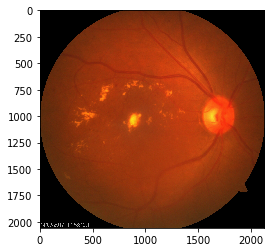

In [25]:
import matplotlib.pyplot as plot
import matplotlib.image as mpimg
import numpy as np

query_img = mpimg.imread(query_img_path)
plot.imshow(query_img)
#axis('off')

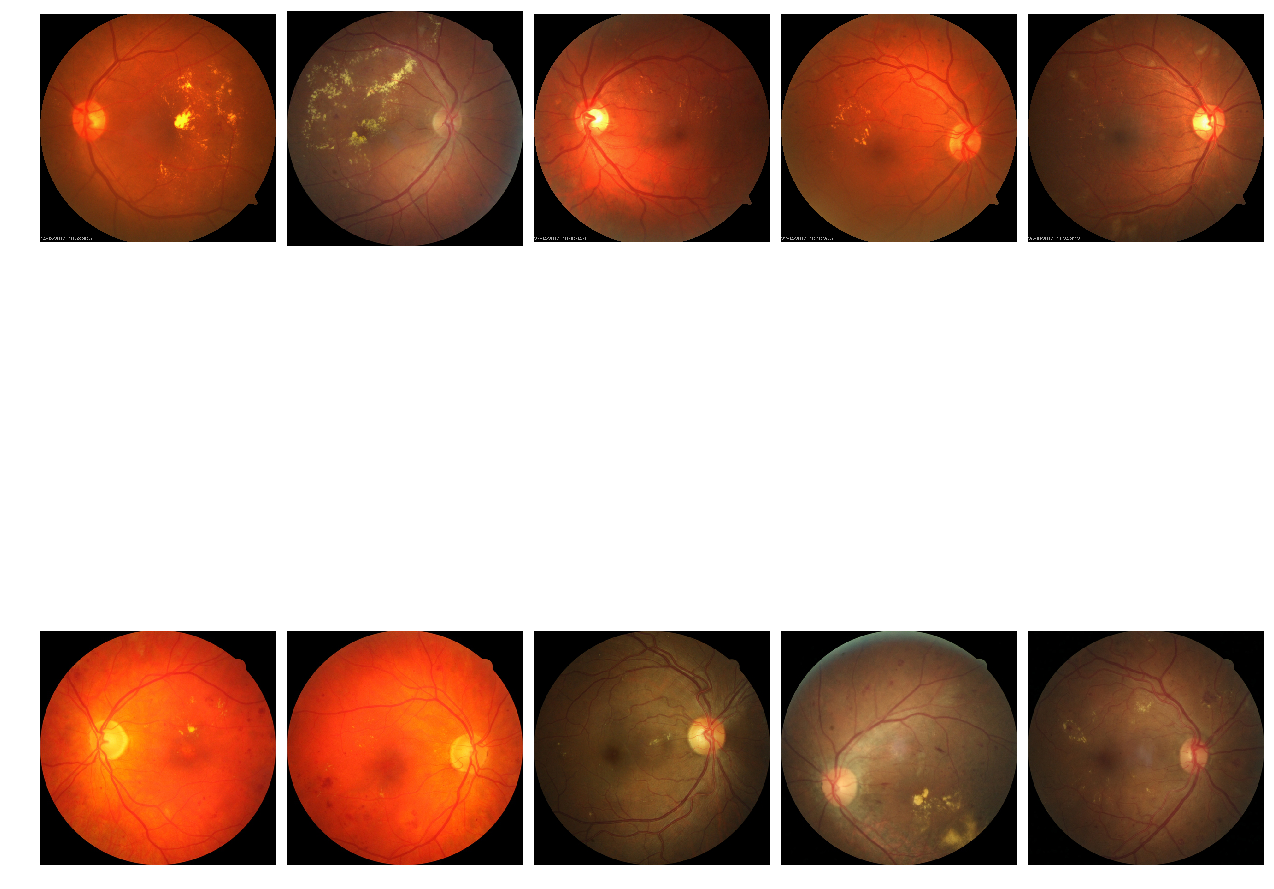

In [26]:
from matplotlib.pyplot import figure, imshow, axis, subplots
from matplotlib.image import imread

hSize = 20
wSize = 20
col = 5

def showImagesMatrix(list_of_files, col=10):
    fig = figure(figsize=(wSize, hSize))
    #fig.subplots_adjust(wspace=0, hspace=0)
    fig.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.05, wspace=0.05)
    number_of_files = len(list_of_files)
    row = number_of_files/col
    if (number_of_files%col != 0):
        row += 1
    for i in range(number_of_files):
        a=fig.add_subplot(row,col,i+1)
        a.set_aspect('equal')
        image = imread(list_of_files[i])
        imshow(image)
        axis('off')


showImagesMatrix(dataset['img_path'].tolist(),col)

In [ ]:
#calculate deep semantic hash code and identify relevent cluster.
#Then retrieve the iamges which have hamming distance < 0.5 and sort according to the cosine similarity in feature space

In [1]:
from sklearn.metrics import jaccard_similarity_score

print(jaccard_similarity_score([1, 1, 0, 0], [1, 0, 1, 0]))

0.5


In [3]:
from ast import literal_eval
from io import StringIO
import pandas as pd

txt = """col1|col2
a|[1,2,3]
b|[4,5,6]"""

df = pd.read_csv(StringIO(txt), sep='|', converters=dict(col2=literal_eval))
print(df)


  col1       col2
0    a  [1, 2, 3]
1    b  [4, 5, 6]


In [4]:
df['newcolumn'] = df.apply(lambda x: get_jaccard_similarity_score(x['col2'], [1, 1, 1]), axis=1)
print(df)

  col1       col2  newcolumn
0    a  [1, 2, 3]   0.333333
1    b  [4, 5, 6]   0.000000


In [9]:
df.sort_values(by='newcolumn', ascending=False).head(10)

,col1,col2,newcolumn
0,a,"[1, 2, 3]",0.333333
1,b,"[4, 5, 6]",0.000000


In [21]:
from scipy import spatial

dataSetI = [1, 0, -1]
dataSetII = [-1,-1, 0]
result = 1 - spatial.distance.cosine(dataSetI, dataSetII)
print(result)

-0.5


In [23]:
df['new_column'] = df.apply(lambda x: get_cosine_similarity_score(x['col2'], [1, 1, 1]), axis=1)
print(df)

  col1       col2  newcolumn  new_column
0    a  [1, 2, 3]   0.333333    0.925820
1    b  [4, 5, 6]   0.000000    0.986928


In [24]:
threshold = 0.3
df = df.loc[df['newcolumn'] >= threshold]
print(df)

  col1       col2  newcolumn  new_column
0    a  [1, 2, 3]   0.333333     0.92582


In [73]:
def convert(list): 
      
    # Converting integer list to string list 
    # and joining the list using join() 
    res = "".join(map(str, list)) 
      
    return res 
  
# Driver code 
list = [0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1] 
new_list = convert(list)
print(type(new_list)) 
print(new_list)

<class 'str'>
000101100000011


In [76]:
a = 'toned'
b = 'roses'
print (get_hamming_distance_str(a, b))

0.6
